# UNet model for image segmentation with EfficientNet encoder.

Implemented using tensorflow 2.2.0 with custom train and test step. Original implementation of efficient() is modified to tensorflow 2.2 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import *

import collections
import math
import string


keras.backend.clear_session()
tf.__version__

'2.5.0'

In [ ]:
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'strides', 'se_ratio', 'final_bn'
])

BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        # EfficientNet actually uses an untruncated normal distribution for
        # initializing conv layers, but keras.initializers.VarianceScaling use
        # a truncated distribution.
        # We decided against a custom initializer for better serializability.
        'distribution': 'normal'
    }
}

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}

DEFAULT_BLOCKS_ARGS = [
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16,
              expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25, 
              final_bn=True),
    BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25, 
              final_bn=True),
    BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25, 
              final_bn=True),
    BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25,
              final_bn=True),
    BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25,
              final_bn=True),
    BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25,
              final_bn=True),
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320,
              expand_ratio=6, id_skip=False, strides=[1, 1], se_ratio=0.25,
              final_bn=False)
    
]

ENCODER_LAYERS = [ 'block2a', 'block3a', 'block4a',  'block6a']

# Squeeze and excitation layer

In [ ]:
class SEBlock(Layer):
    """Implementation of Squeeze and Excitation network"""
    def __init__(self, name, filters, ratio, kernel_initializer, 
                    activation=tf.nn.swish):
        super(SEBlock, self).__init__(name)

        self.squeeze = GlobalAveragePooling2D(name='se_squeeze')
        self.reduce = Conv2D(filters * ratio, 
                                kernel_size=1,
                                activation=activation, 
                                padding='same',
                                use_bias=True,
                                kernel_initializer=kernel_initializer,
                                name='se_reduce')

        self.expand = Conv2D(filters, 
                                kernel_size=1,
                                activation='sigmoid',
                                padding='same',
                                use_bias=True,
                                kernel_initializer=kernel_initializer,
                                name='se_expand')

    def call(self, input):
        x = self.squeeze(input)
        channels = x.shape[-1]
        x = tf.reshape(x, (-1, 1, 1, channels))
        x = self.reduce(x)
        x = self.expand(x)
        return x

# Mobile inverted convolution Layer

In [ ]:
enc = None
class MBConvBlock(Layer):
    def __init__(self, block_args, kernel_initializer, drop_rate=None, 
                 name='', activation=tf.nn.swish):
        super(MBConvBlock, self).__init__(name=name)
        filters = block_args.input_filters * block_args.expand_ratio
        self.block_args = block_args
        if block_args.expand_ratio != 1:
            self.expand_conv = Conv2D(filters, 1, padding='same', 
                                        use_bias=False,
                                        kernel_initializer=kernel_initializer,
                                        name='expand_cov')
            self.expand_bn = BatchNormalization(axis=3, name='expand_bn')
            self.expand_act = Activation(activation, name='expand_activation')

        self.depth_conv = DepthwiseConv2D(block_args.kernel_size,
                              strides=block_args.strides,
                              padding='same',
                              use_bias=False,
                              depthwise_initializer=kernel_initializer,
                              name='dwconv')
        self.depth_bn = BatchNormalization(axis=3, name='bn')
        self.depth_act = Activation(activation, name='activation')

        if block_args.se_ratio > 0:
            self.se_block = SEBlock('se', filters , block_args.se_ratio, 
                                    kernel_initializer)

        self.out_conv = Conv2D(block_args.output_filters, 1, 
                                padding='same',
                                use_bias=False,
                                kernel_initializer=kernel_initializer,
                                name='project')
        
        self.out_bn =  BatchNormalization(axis=3, name='project_bn')

    def call(self, input, training):
        x = input
        if self.block_args.expand_ratio != 1:
            x = self.expand_conv(x)
            x = self.expand_bn(x)
            x = self.expand_act(x)
            global enc
            enc = x

        x = self.depth_conv(x)
        x = self.depth_bn(x)
        x = self.depth_act(x)

        if self.block_args.se_ratio > 0:
            se = self.se_block(x)
            x = tf.math.multiply(x, se)

        x = self.out_conv(x)
        if self.block_args.final_bn:
          x = self.out_bn(x)

        if self.block_args.id_skip and \
              self.block_args.input_filters == self.block_args.output_filters:
            x = tf.math.add(x, input)

        return x, enc

# Encoder EfficientNet

Block2a expand, Block3a expand, Block6a expand, Block7a project layers are used as encoder output 

In [ ]:
class EfficientNet(Layer):
    """Implementation of base Efficient net"""
    def __init__(self, width_coefficient, 
                    depth_coefficient, 
                    dropout_rate=0.2,
                    drop_connect_rate=0.2,
                    depth_divisor=8,
                    activation=tf.nn.swish,
                    blocks_args=DEFAULT_BLOCKS_ARGS,
                    encoder_layers=ENCODER_LAYERS,
                    layer_name='efficient_net',
                    weights='imagenet'):
      super(EfficientNet, self).__init__(layer_name)
      self.layer_name = layer_name
      self.block_args = blocks_args
      self.encoder_layers = encoder_layers
      

      #stem 
      self.stem_conv = Conv2D(self.round_filters(32, width_coefficient, depth_divisor), 3,
                              strides=(2,2),
                              padding='same',
                              use_bias=False,
                              kernel_initializer=CONV_KERNEL_INITIALIZER,
                              name='stem_conv')
      self.stem_bn = BatchNormalization(axis=3, name='stem_bn')
      self.stem_act = Activation(activation, name='stem_Activation')

      self.mb_blocks = {}
      for idx, block_args in enumerate(blocks_args):
          block_args = block_args._replace(
              input_filters=self.round_filters(block_args.input_filters,
                                      width_coefficient, depth_divisor),
              output_filters=self.round_filters(block_args.output_filters,
                                        width_coefficient, depth_divisor),
              num_repeat=self.round_repeats(block_args.num_repeat, depth_coefficient))
          self.mb_blocks.update({f'block{idx + 1}a' : 
                              MBConvBlock(block_args, CONV_KERNEL_INITIALIZER ,
                                  drop_rate=None, name=f'block{idx + 1}a')})
          if idx < (len(blocks_args) - 1):
            for bidx in range((block_args.num_repeat - 1)):
                block_prefix = f'block{idx + 1}{string.ascii_lowercase[bidx + 1]}'
                block_args = block_args._replace(input_filters=block_args.output_filters, 
                                                  strides=[1, 1])
                self.mb_blocks.update({block_prefix : MBConvBlock(block_args, 
                                            CONV_KERNEL_INITIALIZER,
                                            drop_rate=None, name=block_prefix)})
              


    def call(self, input, training=True):
      self.output_layers = []
      x = self.stem_conv(input)
      x = self.stem_bn(x)
      x = self.stem_act(x) # 64 * 64

      for key in self.mb_blocks.keys():
        block = self.mb_blocks[key] 
        global enc
        x, enc = block(x, training) 
        if key in self.encoder_layers:
          self.output_layers.append(enc) # 64, 32, 16, 8, 4

      self.output_layers.append(x)
      return self.output_layers

    def get_config(self):
      return {'layer_name': self.layer_name}


    def round_filters(self, filters, width_coefficient, 
                            depth_divisor):
      """Round number of filters based on width multiplier."""
      filters *= width_coefficient
      new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
      new_filters = max(depth_divisor, new_filters)
      # Make sure that round down does not go down by more than 10%.
      if new_filters < 0.9 * filters:
          new_filters += depth_divisor
      return int(new_filters)

    def round_repeats(self, repeats, depth_coefficient):
      return int(math.ceil(depth_coefficient * repeats))


# Decoder 

In [ ]:
class DecoderBlock(Layer):
    def __init__(self, filters1, filters2, name, kernel_size=3):
      super(DecoderBlock, self).__init__(name=name)

      self.conv_1 = Conv2D(filters1, kernel_size=1, name='conv_1')
      self.bn_1 = BatchNormalization(name='conv_bn_1')
      self.act_1 = Activation('relu', name='conv_relu_1')

      self.up = Conv2DTranspose(filters1, kernel_size, 
                      strides=(2, 2), padding='same', name='up')
      self.up_bn = BatchNormalization(name='up_bn')
      self.up_relu = Activation('relu', name='up_act')

      self.conv_2 = Conv2D(filters2, kernel_size=1, name='conv_2')
      self.bn_2 = BatchNormalization(name='conv_bn_2')
      self.act_2 = Activation('relu', name='conv_relu_2')


    def call(self, input):
      x = self.conv_1(input)
      x = self.bn_1(x)
      x = self.act_1(x)

      x = self.up(x)
      x = self.up_bn(x)
      x = self.up_relu(x)

      x = self.conv_2(x)
      x = self.bn_2(x)
      x = self.act_2(x)

      return x

In [ ]:
class Decoder(Layer):
    def __init__(self, start_filters, name='decoder'):
      super(Decoder, self).__init__(name)
      name = name

      self.decoder4 = DecoderBlock(start_filters * 32, 
                                      start_filters * 16, name='decoder4', kernel_size=3)
      self.decoder3 = DecoderBlock(start_filters * 16, 
                                      start_filters * 8, name='decoder3', kernel_size=3)
      self.decoder2 = DecoderBlock(start_filters * 8, 
                                      start_filters * 4, name='decoder2', kernel_size=3)
      self.decoder1 = DecoderBlock(start_filters * 4, 
                                      start_filters * 2, name='decoder1', kernel_size=3)


    def call(self, encoder):
      #e0 - 64, e1 - 32, e2 - 16, e3 - 8, e4 - 4
      em, e4, e3, e2, e1 = encoder


      d4 = self.decoder4(em) # 8 -> 16
      d4 = tf.concat([d4, e4], axis=-1)

      
      d3 = self.decoder3(d4) # 16 -> 32
      d3 = tf.concat([d3, e3], axis=-1)

      d2 = self.decoder2(d3) # 32 -> 64
      d2 = tf.concat([d2, e2], axis=-1)

      d1 = self.decoder1(d2) # 64 -> 128
      d1 = tf.concat([d1, e1], axis=-1)
      
      return d1

# UNet model which uses EfficientNet B5 encoders

Used custom train and test step 

In [ ]:
class UNet(Model):
    def __init__(self, name, width_coefficient=1, 
                                   depth_coefficient=1, num_classes=2):
        super(UNet, self).__init__(name=name)
        # self.name = name 
        start_filters = 16
        self.backbone = EfficientNet(width_coefficient=width_coefficient, 
                                     depth_coefficient=depth_coefficient)
        
        self.middle_conv = Conv2D(start_filters * 32, kernel_size=3, 
                                    padding='same', name='middle_conv')
        self.middle_bn = BatchNormalization(axis=3, name='middle_bn')
        self.middle_act = Activation('relu', name='middle_activation')

        self.decoder = Decoder(start_filters)

        self.out_conv = Conv2DTranspose(num_classes, 3, strides=2,
                            padding='same', name='out_conv') 
        
        

    def call(self, input, training):
        encoders = self.backbone(input)
        e1, e2, e3, e4, e5 = encoders 

        # #middle block
        em = self.middle_conv(e5)
        em = self.middle_bn(em)
        em = self.middle_act(em) 

        encoders = [em, e4, e3, e2, e1]
        mask = self.decoder(encoders)

        mask = self.out_conv(mask)
    
        return mask


    def compile(self, optimizer, loss_fn, train_loss, test_loss,
                    metric):
      super(UNet, self).compile(optimizer, metrics=metric)
      self.optimizer = optimizer 
      self.loss_fn = loss_fn

      self.train_loss = train_loss
      self.test_loss = test_loss

  
    def train_step(self, data):
        images, mask = data 
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = self.loss_fn(mask, predictions)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.train_loss(loss)
        self.compiled_metrics.update_state(mask, predictions)
        mean_iou = self.metrics[0]

        return {'loss': self.train_loss.result(), \
                    mean_iou.name: mean_iou.result()}


    def test_step(self, data):
        images, mask = data 

        predictions = self(images, training=False)
        loss = self.loss_fn(mask, predictions)

        self.test_loss(loss)
        self.compiled_metrics.update_state(mask, predictions)
        mean_iou = self.metrics[0]

        return {'loss': self.test_loss.result(), \
                    mean_iou.name: mean_iou.result()}


# Sample data from tfds

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

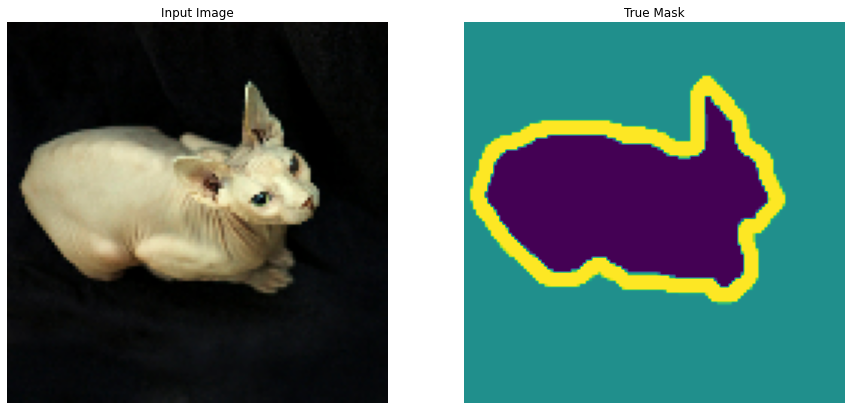

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

# Build and Compile the model 

In [ ]:
model = UNet(name='Unet-efficientNet', 
             width_coefficient=1.6, 
             depth_coefficient=2.2, 
             num_classes=3)

model.build((1, 128, 128, 3))

train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              train_loss=train_loss, test_loss=test_loss,
              metric = ['accuracy'])



In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

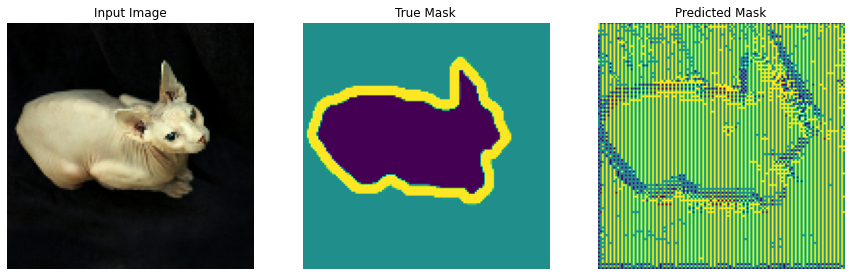

In [ ]:
show_predictions()

# Display callback to show the predictions after end of every epoch

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# Run the model using keras fit

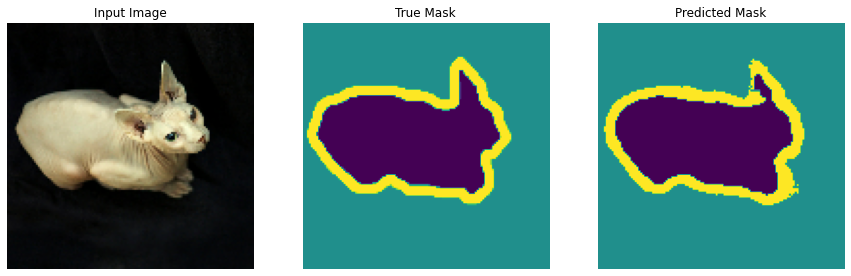


Sample Prediction after epoch 20



In [ ]:




EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
 mask[0].shape()

In [ ]:
!nvidia-msi

/bin/bash: nvidia-msi: command not found
